Image Classification

In [1]:
%matplotlib inline

import sys
from functools import partial

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

from models.resnet import resnet18, resnet34, resnet50, resnet101, resnet152
from models.efficientnet import efficientnet_b0, efficientnetv2_s

torch.manual_seed(0)

Choose dataset.

In [2]:
# available datasets: 'cifar10', 'cifar100', 'mnist', 'emnist'
_dataset = 'cifar10'

if _dataset == 'cifar10':
    dataset = datasets.CIFAR10
elif _dataset == 'cifar100':
    dataset = datasets.CIFAR100
elif _dataset == 'mnist':
    dataset = datasets.MNIST
elif _dataset == 'emnist':
    dataset = partial(datasets.EMNIST, split='letters')
else:
    raise ValueError('dataset only supports {cifar10|cifar100|mnist|emnist}')

Compute mean and std.

Files already downloaded and verified
frog truck truck deer
tensor([0.4914, 0.4822, 0.4465], dtype=torch.float64)
tensor([0.0610, 0.0593, 0.0684], dtype=torch.float64)


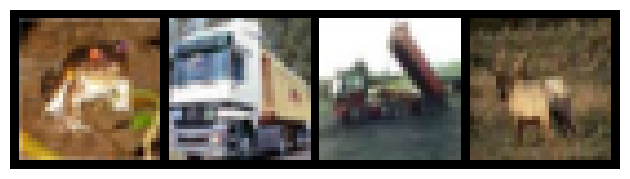

In [3]:
batch_size = 256
num_workers = 8

trainset = dataset(root='./data', train=True, transform=transforms.ToTensor(), download=True)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)

classes = trainset.classes
num_classes = len(classes)
num_images = len(trainset)

images, labels = next(iter(trainloader))

size = images.size(dim=2)
channels = images.size(dim=1)

fig, ax = plt.subplots()
ax.imshow(torch.permute(make_grid(images[:4]), dims=(1, 2, 0)).numpy())
ax.axis('off')
plt.tight_layout()
print(' '.join(f'{classes[labels[j]]}' for j in range(4)))

count = torch.zeros(channels, dtype=torch.int64)
sum = torch.zeros(channels, dtype=torch.float64)
ss = torch.zeros(channels, dtype=torch.float64)

for images, labels in trainloader:
    count += images.size(0) * images.size(2) * images.size(3)
    sum += torch.sum(images, dim=(0, 2, 3))
    ss += torch.sum(torch.square(images), dim=(0, 2, 3))

mean = torch.div(sum, count)
std = torch.sub(torch.div(ss, count), torch.square(mean))

print(mean)
print(std)

Choose batch size, number of workers. Build dataloader.

In [4]:
batch_size = 128
num_workers = 8

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

trainset = dataset(root='./data', train=True, transform=transform, download=True)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=False)

testset = dataset(root='./data', train=False, transform=transform, download=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)

Files already downloaded and verified
Files already downloaded and verified


Choose device, model.

In [5]:
_device = 'cuda'
device = torch.device(_device)

model = resnet18(size=size, in_channels=channels, num_classes=num_classes, dropout=0.2)
model.to(device)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layers): Sequential(
    (0): Sequential(
      (0): BasicBlock(
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (1): BasicBlock(
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, mome

Choose epochs, steps, lr, weight decay, optimizer, scheduler.

In [6]:
epochs = 200
steps = 50

lr = 1e-3
weight_decay = 3e-4
T_0 = 1
T_mult = 2

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=T_0, T_mult=T_mult)

Load model if you want.

In [7]:
load = False

if load:
    state = torch.load('./model.pt')

    model.load_state_dict(state['model'])
    optimizer.load_state_dict(state['optimizer'])
    scheduler.load_state_dict(state['scheduler'])

    load_epoch = state['epoch']
    cycle = state['cycle']
    T_i = state['T_i']
    best_accuracy = state['best_accuracy']
else:
    load_epoch = 1
    cycle = 0
    T_i = T_0
    best_accuracy = 0.0

Train model. Redirect stdout to a log file. Save the best model at every cycle of lr scheduler.

In [8]:
stdout = sys.stdout
f = open('model.log', 'w')
sys.stdout = f

T_cur = 0
for epoch in range(load_epoch - 1, epochs):
    running_loss = 0.0
    running_correct = 0
    running_count = 0
    for step, (images, labels) in enumerate(trainloader):
        model.train()
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss += loss.item()
        running_correct += torch.sum(torch.argmax(outputs, dim=-1) == labels).item()
        running_count += images.size(dim=0)

        if (step + 1) % steps == 0:
            print(f'[Epoch {epoch + 1:02d}] [Step {step + 1:04d}] Loss: {running_loss / (step + 1):.4f}, Accuracy: {running_correct / running_count:.4f}')

        T_cur += 1

        if T_cur == T_i:
            cycle += 1
            T_i *= T_mult
            T_cur = 0

            correct = 0
            count = 0
            with torch.no_grad():
                for images, labels in testloader:
                    model.eval()
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)

                    correct += torch.sum(torch.argmax(outputs, dim=-1) == labels).item()
                    count += images.size(dim=0)

            accuracy = correct / count
            print(f'[Cycle {cycle:02d}] Accuracy: {accuracy:.4f}, Best accuracy: {best_accuracy:.4f}')

            if accuracy > best_accuracy:
                state = {
                    'model': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'scheduler': scheduler.state_dict(),
                    'epoch': epoch + 1,
                    'cycle': cycle,
                    'T_i': T_i,
                    'best_accuracy': best_accuracy,
                }

                torch.save(state, 'model.pt')
                best_accuracy = accuracy
                print('New best accuracy, saved model.')

sys.stdout = stdout
f.close()

/home/ik/anaconda3/envs/vision/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Test model.

In [ ]:
state = torch.load('./model.pt')

model.load_state_dict(state['model'])

correct = 0
count = 0
with torch.no_grad():
    for images, labels in testloader:
        model.eval()
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        correct += torch.sum(torch.argmax(outputs, dim=-1) == labels).item()
        count += images.size(dim=0)

accuracy = correct / count
print(f'Test accuracy: {accuracy:.4f}')

/home/ik/anaconda3/envs/vision/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Test accuracy: 0.7809
